## [Middleware](https://docs.langchain.com/oss/python/langchain/middleware)
**agent에 대해서 아래 과정의 hook을 확보할 수 있다.**

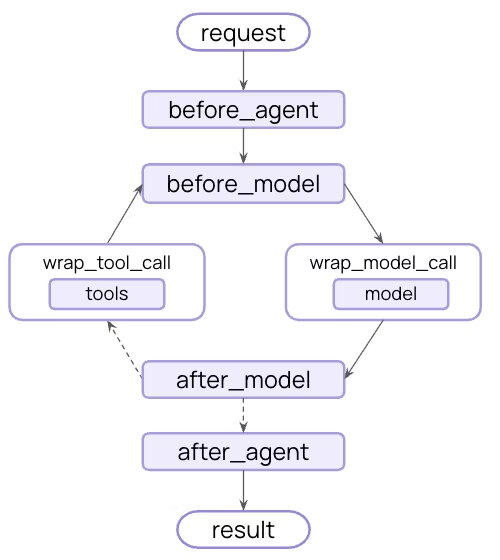

### Middleware가 하는 일!
- **Monitor**: 로깅, 통계, 디버깅 등 추적
- **Modify**: prompt, tool 선택, 출력 등을 변경
- **Control**: 재시도, 복구, 조기종료 로직 등을 추가
- **Enforce**: rate limit, guardrails, PLL detection 등을 적용

### 이 노트북에서 시험하는 것들
1. Built-in middleware
2. Custom middleware
    - decorator-based
    - class-based

In [7]:
from util.ai_models import llm, llm_small, llm_large

In [2]:
from langchain.agents import create_agent
from langchain.agents.middleware import TodoListMiddleware
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool


@tool
def read_file(file_path: str) -> str:
    """Read contents of a file."""
    with open(file_path) as f:
        return f.read()


@tool
def write_file(file_path: str, content: str) -> str:
    """Write content to a file."""
    with open(file_path, 'w') as f:
        f.write(content)
    return f"Wrote {len(content)} characters to {file_path}"


@tool
def run_tests(test_path: str) -> str:
    """Run tests and return results."""
    # Simplified for example
    return "All tests passed!"


agent = create_agent(
    model=llm_small,
    tools=[read_file, write_file, run_tests],
    middleware=[TodoListMiddleware()],
)

# result = agent.invoke({
#     "messages": [HumanMessage("Refactor the authentication module to use async/await and ensure all tests pass")]
# })

# # The agent will use write_todos to plan and track:
# # 1. Read current authentication module code
# # 2. Identify functions that need async conversion
# # 3. Refactor functions to async/await
# # 4. Update function calls throughout codebase
# # 5. Run tests and fix any failures

# print(result["todos"])  # Track the agent's progress through each step

### [Custom decoreator-based middleware](https://docs.langchain.com/oss/python/langchain/middleware#decorator-based-middleware)

**`@dynamic_prompt`**:

모델 호출 전, ModelRequest의 system_prompt를 수정한다.

따라서 wrap_model_call 이전에 변경하게 되는 것.

또한, 호출할 때 매번 시스템 프롬프트를 메시지 첫번째에 포함시키기 때문에 state["messages"]에는 저장되지 않는다.

그리고 before_model이 먼저 실행되고, dynamic_prompt가 실행되는 것으로 보인다.

before_model은 말 그대로 model 호출 전 수행되는 과정이고, dynamic_prompt는 호출 직전에 system_prompt를 update하고 호출하도록 되어 있기 때문으로 보인다.

In [3]:
from langchain.agents.middleware import before_model, after_model, wrap_model_call
from langchain.agents.middleware import AgentState, ModelRequest, ModelResponse, dynamic_prompt
from langchain.messages import AIMessage
from langchain.agents import create_agent
from langgraph.runtime import Runtime
from typing import Any, Callable, cast
from pydantic import BaseModel

from util.testhelper import calculate_price_by_token

# Define context schema as a Pydantic model
class UserContext(BaseModel):
    user_id: str = "guest"

@before_model
def log_before_model(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    print(f"last message before model: {state["messages"][-1]}")
    return None

@before_model
def change_context_before_model(state: AgentState, runtime: Runtime[UserContext]) -> dict[str, Any] | None:
    runtime.context.user_id = "daehan"
    return None

# Wrap-style: dynamic prompts
@dynamic_prompt
def personalized_prompt(request: ModelRequest) -> str:
    user_id = request.runtime.context.user_id
    new_prompt = f"당신은 {user_id} 유저의 친절한 도우미 에이전트입니다. 유저의 아이디를 언급하며 친절하게 응대하세요."
    print(f"기존 시스템 프롬프트: {request.system_prompt}")
    print(f"새 시스템 프롬프트: {new_prompt}")
    
    return new_prompt

@wrap_model_call
def track_system_message(
    request: ModelRequest,
    handler: Callable[[ModelRequest], ModelResponse],
) -> ModelResponse:
    print(f"기존 시스템 프롬프트: {request.system_prompt}")

    context = cast(UserContext, request.runtime.context)
    user_id = context.user_id
    request.system_prompt = f"당신은 {user_id} 유저의 친절한 도우미 에이전트입니다. 유저의 아이디를 언급하며 친절하게 응대하세요."

    print("모델 호출 시스템 프롬프트:", request.system_prompt)
    return handler(request)

@after_model(can_jump_to=["end"])
def calculate_call_price(state: AgentState, runtime: Runtime) -> dict[str, Any] | None:
    last_message = state["messages"][-1]

    p_in, p_out = calculate_price_by_token(last_message.model_dump())

    print(f"입력 토큰 비용: {p_in}, 출력 토큰 비용: {p_out}, 총비용: {p_in+p_out}")
    return None


@dynamic_prompt
def state_aware_prompt(request: ModelRequest) -> str:
    # request.messages is a shortcut for request.state["messages"]
    message_count = len(request.messages)

    base = "You are a helpful assistant."

    if message_count > 10:
        base += "\nThis is a long conversation - be extra concise."

    return base

# Use decorators in agent
agent = create_agent(
    model=llm_small,
    middleware=[track_system_message, change_context_before_model, calculate_call_price],
    context_schema=UserContext,
    system_prompt="당신은 유저의 도우미 에이전트입니다."
)

response = agent.invoke({"messages": [HumanMessage("안녕하세요!")]}, context={"user_id": "minha"})

print(response["messages"][-1])

기존 시스템 프롬프트: 당신은 유저의 도우미 에이전트입니다.
모델 호출 시스템 프롬프트: 당신은 daehan 유저의 친절한 도우미 에이전트입니다. 유저의 아이디를 언급하며 친절하게 응대하세요.
입력 토큰 비용: 1.17e-05, 출력 토큰 비용: 3.5000000000000004e-05, 총비용: 4.6700000000000003e-05
content='안녕하세요, daehan님! 무엇을 도와드릴까요? 😊' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'} id='lc_run--6b9b601a-b40b-4702-9df7-4dcae9926d46-0' usage_metadata={'input_tokens': 39, 'output_tokens': 14, 'total_tokens': 53, 'input_token_details': {'cache_read': 0}}


In [ ]:
from util.testhelper import print_messages
print_messages(response["messages"])


📨 총 2개의 메시지

index: 1,
type": HUMAN
{
   "content": "안녕하세요!",
   "metadata": {
      "content": "안녕하세요!",
      "additional_kwargs": {},
      "response_metadata": {},
      "type": "human",
      "name": null,
      "id": "09a9e18a-6be7-4a7e-8897-dc3001873459"
   }
}
--------------------------------------------------------------------------------

index: 2,
type": AI
{
   "content": "안녕하세요, daehan님! 무엇을 도와드릴까요? 😊",
   "metadata": {
      "content": "안녕하세요, daehan님! 무엇을 도와드릴까요? 😊",
      "additional_kwargs": {},
      "response_metadata": {
         "prompt_feedback": {
            "block_reason": 0,
            "safety_ratings": []
         },
         "finish_reason": "STOP",
         "model_name": "gemini-2.5-flash-lite",
         "safety_ratings": [],
         "grounding_metadata": {},
         "model_provider": "google_genai"
      },
      "type": "ai",
      "name": null,
      "id": "lc_run--6b9b601a-b40b-4702-9df7-4dcae9926d46-0",
      "tool_calls": [],
      "invalid_tool_c

### Class-based Middleware

In [ ]:
from langchain.agents.middleware import AgentMiddleware, ModelRequest, ModelResponse
from typing import Callable

class RetryMiddleware(AgentMiddleware):
    def __init__(self, max_retries: int = 3):
        super().__init__()
        self.max_retries = max_retries

    def wrap_model_call(
        self,
        request: ModelRequest,
        handler: Callable[[ModelRequest], ModelResponse],
    ) -> ModelResponse:
        for attempt in range(self.max_retries):
            try:
                return handler(request)
            except Exception as e:
                if attempt == self.max_retries - 1:
                    raise
                print(f"Retry {attempt + 1}/{self.max_retries} after error: {e}")

In [ ]:
from langchain.agents.middleware import AgentMiddleware, ModelRequest, ModelResponse
from langchain.chat_models import init_chat_model
from typing import Callable

class DynamicModelMiddleware(AgentMiddleware):
    def wrap_model_call(
        self,
        request: ModelRequest,
        handler: Callable[[ModelRequest], ModelResponse],
    ) -> ModelResponse:
        # Use different model based on conversation length
        if len(request.messages) > 10:
            request.model = init_chat_model("gpt-4o")
        else:
            request.model = init_chat_model("gpt-4o-mini")

        return handler(request)

In [ ]:
from langchain.tools.tool_node import ToolCallRequest
from langchain.agents.middleware import AgentMiddleware
from langchain_core.messages import ToolMessage
from langgraph.types import Command
from typing import Callable

class ToolMonitoringMiddleware(AgentMiddleware):
    def wrap_tool_call(
        self,
        request: ToolCallRequest,
        handler: Callable[[ToolCallRequest], ToolMessage | Command],
    ) -> ToolMessage | Command:
        print(f"Executing tool: {request.tool_call['name']}")
        print(f"Arguments: {request.tool_call['args']}")

        try:
            result = handler(request)
            print(f"Tool completed successfully")
            return result
        except Exception as e:
            print(f"Tool failed: {e}")
            raise

In [ ]:
from langchain.agents.middleware import AgentState, AgentMiddleware
from typing_extensions import NotRequired
from typing import Any

class CustomState(AgentState):
    model_call_count: NotRequired[int]
    user_id: NotRequired[str]

class CallCounterMiddleware(AgentMiddleware[CustomState]):
    state_schema = CustomState

    def before_model(self, state: CustomState, runtime) -> dict[str, Any] | None:
        # Access custom state properties
        count = state.get("model_call_count", 0)

        if count > 10:
            return {"jump_to": "end"}

        return None

    def after_model(self, state: CustomState, runtime) -> dict[str, Any] | None:
        # Update custom state
        return {"model_call_count": state.get("model_call_count", 0) + 1}

In [ ]:
from collections.abc import Callable


from langchain_core.messages import ToolMessage
from langgraph.prebuilt.tool_node import ToolCallRequest
from langgraph.types import Command


class ToolTrackingState(AgentState):
    total_input_cost: NotRequired[float]
    total_output_cost: NotRequired[float]


class TokenTrackingMiddleware(AgentMiddleware[ToolTrackingState]):
    """Agent와 Tool 실행 시 토큰 비용을 자동 추적하는 미들웨어"""
    def __init__(self, debug: bool = False) -> None:
        self.debug = debug
    
    def wrap_tool_call(
        self,
        request: ToolCallRequest,
        handler: Callable[[ToolCallRequest], ToolMessage | Command]
    ) -> ToolMessage | Command:
        if self.debug:
            print(f"Executing tool: {request.tool_call['name']}")
            print(f"Arguments: {request.tool_call['args']}")
        
        try:
            result = handler(request)

            if isinstance(result, ToolMessage):
                return result

            return Command(update={
                
            })
        except Exception as e:
            print(f"Tool failed: {e}")
            raise